Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

Example Tutorial for Australian Domestic Tourism
[1] https://nixtlaverse.nixtla.io/hierarchicalforecast/examples/australiandomestictourism.html


For Non-Negative Reconcilitation.
[3] https://nixtlaverse.nixtla.io/hierarchicalforecast/examples/nonnegativereconciliation.html

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import darts
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.models.forecasting.arima import ARIMA
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality, plot_acf

import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.models import ExponentialSmoothing, NaiveSeasonal
from darts.utils.utils import ModelMode
from darts.dataprocessing.transformers import Scaler

import numpy as np
import pandas as pd

from functools import partial

from sklearn.linear_model import LinearRegression
from mlforecast import MLForecast
from mlforecast.utils import PredictionIntervals

from hierarchicalforecast.utils import aggregate
from hierarchicalforecast.methods import BottomUp, TopDown, MinTrace, ERM
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import evaluate
from hierarchicalforecast.utils import HierarchicalPlot, is_strictly_hierarchical

from statsforecast.models import AutoETS
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, Naive, SeasonalNaive, ADIDA, CrostonClassic, TSB

from utilsforecast.losses import scaled_crps
from utilsforecast.losses import rmse, mase, msse

import warnings

import datetime

from statsmodels.tsa.seasonal import seasonal_decompose, STL , MSTL

import os
from pathlib import Path


pd.set_option('display.max_columns', 500)


In [2]:
from data_processing import resample_time_series, fill_timeseries_gaps, fill_missing_dates

In [ ]:
curr_folder_path = Path(os.path.abspath(""))
base_path = curr_folder_path.parent.absolute()
data_path = os.path.join(base_path, 'data')

df_ds1 = pd.read_csv(os.path.join(data_path, 'dim_ds_new.csv'))

df_ds1.sample(3)

## <p style="background-color:#56BBD1;font-family:newtimeroman;color:#2E3035;font-size:150%;text-align:center;border-radius:10px 10px;">Data Science Task #1</p>

A fim de ajustar a distribuição de produtos e ter uma melhor estimativa sobre a necessidade de compra de matéria prima, faça uma previsão sobre a demanda dos próximos 3 meses de cada produto em cada loja. Além disso, aponte se há ou não a presença de sazonalidade em algum produto de sua escolha.

In order to adjust the distribution of products and have a better estimate the necessity of the purchase of raw materials, I'm planning on creating a model to forecast the demand for the next 3 months for each product in each store. In order to do so, which columns and from which schemas would be necessary to build such model? Be objective.

This notebook draws inspiration from [1].

In [4]:
# 1. Data Loading
# 2. Data Processing
# 3. Hierarchies and reconcilers definition
# 4. Train test split
# 5. Compute base forecasts
# 6. Evaluate (without reconciliation) + Dataviz
# 7. Forecast reconciliation
# 8. Evaluate (with reconciliation) + Dataviz
# 

# Bonus A: Probabilistic Forecast Evaluation



In [5]:
TIME_COL = "ORDER_DATE"
TARGET_COLS = "ORDER_QTY"
FREQ = 'MS'
HORIZON = 4

## Data Processing

Simple data processing to make the dataset clean and contiguous in order to be used in modeling or other stages

In [ ]:

# Select only relevant columns
df = df_ds1[['PRODUCT_NAME', TARGET_COLS, TIME_COL, 'STORE_NAME']]

# Select Products, Stores or Store/Product combination
unique_combinations = df.groupby(['STORE_NAME', 'PRODUCT_NAME']).size()
filtered_combinations = unique_combinations[unique_combinations > 11].index
df = df[df.set_index(['STORE_NAME', 'PRODUCT_NAME']).index.isin(filtered_combinations)]

# Datetime casting
df[TIME_COL] = pd.to_datetime(df[TIME_COL])

# Filling empty stores
df['STORE_NAME'] = df['STORE_NAME'].fillna('E-commerce')

# Fill missing dates
start_date = df[TIME_COL].min()
end_date = df[TIME_COL].max()
df = fill_timeseries_gaps(df, time_col=TIME_COL, target_cols=TARGET_COLS, start_date=start_date, end_date=end_date)

# Resample
df = resample_time_series(df, frequency=FREQ, time_col=TIME_COL, target_cols=TARGET_COLS)

df


### Visualizing the Time Series

In [ ]:
example_store = 'The Gear Store' # Option 1
# example_store = 'Fitness Toy Store' # Option 2

specific_store_df = df[df['STORE_NAME'] == example_store]

plt.figure(figsize=(8, 3))

for product in specific_store_df['PRODUCT_NAME'].unique():
    _df = specific_store_df[specific_store_df['PRODUCT_NAME'] == product]
    sns.lineplot(x=TIME_COL, y=TARGET_COLS, data=_df, errorbar=None) #, color=cerulean
    sns.despine(left=True)

    plt.title('Vendas')
    plt.xlabel('Dia')
    plt.ylabel('Unidades')
    plt.ylim(0, None)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='x')

plt.show()

## Encoding the Hierarchy

Here, I'll test with different reconcilers to try to plot their comparison metrics. In Item 10 and 11, I'll decide to use a single reconciler to reduce computation and memory costs.

In [ ]:
spec = [
    ['STORE_NAME'],
    ['STORE_NAME', 'PRODUCT_NAME'],
]

Y_df, S_df, tags = aggregate(
    df,
    spec,
    time_col=TIME_COL,
    target_cols=[TARGET_COLS]
)


if is_strictly_hierarchical(S=S_df.drop(columns="unique_id").values.astype(np.float32), tags={key: S_df["unique_id"].isin(val).values.nonzero()[0] for key, val in tags.items()}):
    print('is_strictly_hierarchical')
    reconcilers = [
        BottomUp(),
        TopDown(method='average_proportions'),
        TopDown(method='proportion_averages'),
        MinTrace(method='ols'),
        MinTrace(method='ols', nonnegative=True),
        # MinTrace(method='wls_var'),
        # MinTrace(method='mint_shrink'),
        ERM(method='closed')
    ]
else:
    reconcilers = [
        BottomUp(),
        MinTrace(method='ols'),
        MinTrace(method='wls_var'),
        MinTrace(method='mint_shrink'),
        ERM(method='closed')
    ]

eval_tags = {}
eval_tags['Total'] = tags['STORE_NAME']
eval_tags['PRODUCT_NAME'] = tags['STORE_NAME/PRODUCT_NAME']

display(Y_df.head())
print(f"S_df.shape: {S_df.shape}")
display(S_df.iloc[:5, :5])

hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()

## Train Test Separation

In [ ]:
Y_test_df = Y_df.groupby('unique_id', as_index=False).tail(HORIZON)
Y_train_df = Y_df.drop(Y_test_df.index)
Y_train_df


## Modeling

In [10]:
# SeasonalNaive, TSB,  ADIDA
# , CrostonClassic() AutoETS(season_length=4, model='ZZA')
models = [Naive(), AutoARIMA(),]
model_names = [m.__class__.__name__ for m in models]

fcst = StatsForecast(
    models=models,
    freq=FREQ,
    n_jobs=-1,
)
Y_hat_df = fcst.forecast(
    df=Y_train_df,
    h=HORIZON,
    fitted=True,
    time_col=TIME_COL,
    target_col=TARGET_COLS,
)
Y_fitted_df = fcst.forecast_fitted_values()

### Evaluation

In [ ]:
df = Y_hat_df.merge(Y_test_df, on=['unique_id', TIME_COL])
evaluation = evaluate(
    df = df,
    tags = eval_tags,
    train_df = Y_train_df,
    metrics = [rmse, partial(mase, seasonality=4)],
    time_col=TIME_COL,
    target_col=TARGET_COLS,
)

# evaluation.columns = ['level', 'metric'] + model_names
numeric_cols = evaluation.select_dtypes(include="number").columns
evaluation[numeric_cols] = evaluation[numeric_cols].map('{:.2f}'.format).astype(np.float64)

display(evaluation.query('metric == "rmse"'))
display(evaluation.query('metric == "mase"'))


In [ ]:
# Dataviz

eval_df = evaluation.query('metric == "rmse"')

df = eval_df

# Melt the dataframe for seaborn
melted_df = df.melt(id_vars=['level', 'metric'], var_name='Model', value_name='Value')

# Set up the figure and axes
palette = sns.color_palette("husl", n_colors=len(melted_df['Model'].unique()))
fig, axes = plt.subplots(1, len(df['level'].unique()), figsize=(15, 5), sharey=True)

# Loop through levels to create grouped barplots
for i, (ax, level) in enumerate(zip(axes, df['level'].unique())):
    
    # Filter data for the current level
    level_data = melted_df[melted_df['level'] == level]
    
    # Create barplot
    sns.barplot(
        data=level_data,
        x='Model',
        y='Value',
        hue='Model',
        ax=ax,
        palette=palette,
        dodge=False
    )
    
    # Customize each subplot
    ax.set_title(level)
    ax.set_ylabel('Value') if i == 0 else ax.set_ylabel('')  # Only show y-axis label for the first subplot
    ax.set_xlabel('Models')
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


### Visualizing the Predictions (without coherence)

Metrics are nice and important, but it's also crucial to keep our feet on the ground and see if the predictions make sense in a practical way. Here, we will try to see how our predictions for a product in a store stack up against reality.

#### Analysis:

We see that there is a difference between the predictions of our total store's demand and the sum of each product's deman. This is the main reason why the use of some method of reconciliation in hierarchical time series forecast is useful.

Nonetheless, we see that at least for this store, our predictions, even though there are many things which can be corrected, follow similar trends and patterns from the real test data.

In [ ]:
print(example_store)
example_columns = [c for c in Y_train_df['unique_id'].unique() if c.startswith(example_store)]
example_columns = [c for c in Y_train_df['unique_id'].unique() if c.startswith(example_store)]
example_train_df = Y_train_df[Y_train_df['unique_id'].isin(example_columns)]
example_test_df = Y_test_df[Y_test_df['unique_id'].isin(example_columns)]

example_train_df.sample(3)

In [14]:

Y_hat_example_train_df = fcst.forecast(
    df=example_train_df,
    h=HORIZON,
    fitted=True,
    time_col=TIME_COL,
    target_col=TARGET_COLS,
)

In [15]:
predicted_interval = Y_hat_example_train_df[TIME_COL]
example_test_df = example_test_df[example_test_df[TIME_COL].isin(predicted_interval)]

pred_total = Y_hat_example_train_df[Y_hat_example_train_df['unique_id'] == example_store]
pred_sum = Y_hat_example_train_df[Y_hat_example_train_df['unique_id'] != example_store]
pred_sum = pred_sum.groupby(TIME_COL)[["Naive", "AutoARIMA"]].sum().reset_index()

example_test_total = example_test_df[example_test_df['unique_id'] == example_store]
example_test_sum = example_test_df[example_test_df['unique_id'] != example_store]
example_test_sum = example_test_sum.groupby(TIME_COL)[[TARGET_COLS]].sum().reset_index()


In [ ]:
plt.plot(example_test_total[TIME_COL], example_test_total[TARGET_COLS], linewidth=5, color='green', alpha=0.5, label="Predicted Total for the Store")
plt.plot(example_test_sum[TIME_COL], example_test_sum[TARGET_COLS], linewidth=3, linestyle='--', color='#006400', label="Sum of the predictions for the Store's Products")

plt.plot(pred_total[TIME_COL], pred_total['AutoARIMA'], linewidth=5, color='blue', alpha=0.5, label="Predicted Total for the Store")
plt.plot(pred_sum[TIME_COL], pred_sum['AutoARIMA'], linewidth=3, linestyle='--', color='blue', label="Sum of the predictions for the Store's Products")

plt.legend(loc='upper right')


## Reconciliation

In [ ]:

hrec = HierarchicalReconciliation(reconcilers=reconcilers)

Y_rec_df = hrec.reconcile(
    Y_hat_df=Y_hat_df,
    Y_df=Y_fitted_df,
    S=S_df,
    tags=tags,
    time_col=TIME_COL,
    target_col=TARGET_COLS,
)

display(Y_fitted_df.head(3))
display(Y_rec_df.sample(5))


### Evaluation

In [ ]:
# Evaluate with reconciliation
# df = Y_rec_df.merge(Y_test_df, on=['unique_id', TIME_COL], how="left")
eval_df = Y_rec_df.merge(Y_test_df, on=['unique_id', TIME_COL])

evaluation = evaluate(
    df = eval_df,
    tags = eval_tags,
    train_df = Y_train_df,
    metrics = [rmse, partial(mase, seasonality=4)],
    time_col=TIME_COL,
    target_col=TARGET_COLS,
)

# evaluation.columns = ['level', 'metric', 'Base', 'BottomUp', 'MinTrace(mint_shrink)', 'MinTrace(ols)']
numeric_cols = evaluation.select_dtypes(include="number").columns
evaluation[numeric_cols] = evaluation[numeric_cols].map('{:.2f}'.format).astype(np.float64)

display(evaluation.query('metric == "rmse"'))
display(evaluation.query('metric == "mase"'))

In [ ]:
# Dataviz

df = evaluation.query('metric == "rmse"')

# Separate base_columns and rec_columns
columns = df.columns[2:]  # Exclude 'level' and 'metric'
base_columns = [col for col in columns if "/" not in col]
rec_columns = [col for col in columns if "/" in col]

# Group rec_columns by their base column
column_sets = {}
for base in base_columns:
    column_sets[base] = [base] + [col for col in rec_columns if col.startswith(base + "/")]

# Plotting
n_rows = len(df)
n_cols = len(column_sets)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), sharey=False)

for row_idx, (index, row) in enumerate(df.iterrows()):
    for col_idx, (base, col_set) in enumerate(column_sets.items()):
        ax = axes[row_idx, col_idx] if n_rows > 1 else axes[col_idx]

        # Extract data for the column set
        values = row[col_set]
        x = np.arange(len(col_set))
        
        width = 0.8  # Set bar width
        ax.bar(x, values, width=width, color=plt.cm.tab10(np.arange(len(col_set))))
        
        # Formatting
        ax.set_title(f"{base} ({row['level']})")
        ax.set_ylabel(row['metric'])
        ax.set_xticks(x)
        ax.set_xticklabels(col_set, rotation=45, ha="right")

plt.tight_layout()
plt.show()


### Visualizing the Predictions (with coherence)

In [ ]:
# 6. Visualizations

plot_mf = Y_df.merge(Y_rec_df, on=['unique_id', TIME_COL], how="outer")
plot_mf.head(3)

hplot.plot_series(
    series='Vigorous Exercise Company/Sport-100 Helmet, Red',
    Y_df=plot_mf, 
    models=[TARGET_COLS, 'AutoARIMA', 'AutoARIMA/BottomUp', 'AutoARIMA/ERM_method-closed_lambda_reg-0.01', 'AutoARIMA/MinTrace_method-ols_nonnegative-True'],
    level=[80],
    id_col="unique_id",
    time_col=TIME_COL,
    target_col=TARGET_COLS,
)

ax = plt.gca()
# ax.set_xlim([datetime.date(2014, 1, 30), datetime.date(2014, 6, 30)])


### Visualizing the Predictions for a specific Store (with coherence)

Like was done before, the plot for a specific store's prediction will be shown in order to clearly see if the reconciliation is combining the products individual predictions accordingly.

#### Analysis:

As can be seen from the plot generated in this subsection, The purple line now closely follows the cyan line, which demonstrates that the reconciliation is in fact coherently summing the individual product's demands up to the total forecasted deman.

It is important to note though, that since the model is not retrained during the reconciliation process, errors and possibly trends risen from the modeling stage remains, thus, the predicted demand differs from the real demand. 

However, it can be seen the reconciliated demand is much more accurate than the base forecasts.

In [ ]:
print(example_store)
example_columns = [c for c in Y_train_df['unique_id'].unique() if c.startswith(example_store)]
example_columns = [c for c in Y_train_df['unique_id'].unique() if c.startswith(example_store)]
example_rec_df = Y_rec_df[Y_rec_df['unique_id'].isin(example_columns)]
example_test_df = Y_test_df[Y_test_df['unique_id'].isin(example_columns)]

example_rec_df.sample(3)

In [22]:
predicted_interval = example_rec_df[TIME_COL]
example_test_df = example_test_df[example_test_df[TIME_COL].isin(predicted_interval)]

pred_total = example_rec_df[example_rec_df['unique_id'] == example_store]
pred_sum = example_rec_df[example_rec_df['unique_id'] != example_store]
pred_sum = pred_sum.groupby(TIME_COL)[["Naive", "AutoARIMA/MinTrace_method-ols"]].sum().reset_index()

example_test_total = example_test_df[example_test_df['unique_id'] == example_store]
example_test_sum = example_test_df[example_test_df['unique_id'] != example_store]
example_test_sum = example_test_sum.groupby(TIME_COL)[[TARGET_COLS]].sum().reset_index()


In [ ]:
plt.plot(example_test_total[TIME_COL], example_test_total[TARGET_COLS], linewidth=5, color='green', alpha=0.5, label="Predicted Total for the Store")
plt.plot(example_test_sum[TIME_COL], example_test_sum[TARGET_COLS], linewidth=3, linestyle='--', color='#006400', label="Sum of the predictions for the Store's Products")

plt.plot(pred_total[TIME_COL], pred_total['AutoARIMA/MinTrace_method-ols'], linewidth=5, color='blue', alpha=0.5, label="Predicted Total for the Store")
plt.plot(pred_sum[TIME_COL], pred_sum['AutoARIMA/MinTrace_method-ols'], linewidth=3, linestyle='--', color='blue', label="Sum of the predictions for the Store's Products")

plt.legend(loc='upper right')


## <p style="background-color:#56BBD1;font-family:newtimeroman;color:#2E3035;font-size:150%;text-align:center;border-radius:10px 10px;">Bonus A: Probabilistic Forecast Evaluation</p>

"Qualitative evaluation, of parsed quantiles"

Probabilistic Forecast Evaluation
[2] https://nixtlaverse.nixtla.io/hierarchicalforecast/examples/tourismlarge-evaluation.html

In [30]:

LEVEL = np.arange(0, 100, 2)
# qs = [[50-lv/2, 50+lv/2] for lv in LEVEL]
# quantiles = np.sort(np.concatenate(qs)[1:]/100)
intervals_method = 'bootstrap' # normality bootstrap permbu


In [31]:

# Select only relevant columns
df = df_ds1[['PRODUCT_NAME', TARGET_COLS, TIME_COL, 'STORE_NAME']]

# Select Products, Stores or Store/Product combination
unique_combinations = df.groupby(['STORE_NAME', 'PRODUCT_NAME']).size()
filtered_combinations = unique_combinations[unique_combinations > 11].index
df = df[df.set_index(['STORE_NAME', 'PRODUCT_NAME']).index.isin(filtered_combinations)]

# Datetime casting
df[TIME_COL] = pd.to_datetime(df[TIME_COL])

# Filling empty stores
df['STORE_NAME'] = df['STORE_NAME'].fillna('E-commerce')

# Fill missing dates
start_date = df[TIME_COL].min()
end_date = df[TIME_COL].max()
df = fill_timeseries_gaps(df, time_col=TIME_COL, target_cols=TARGET_COLS, start_date=start_date, end_date=end_date)

# Resample
df = resample_time_series(df, frequency=FREQ, time_col=TIME_COL, target_cols=TARGET_COLS)

df


,ORDER_DATE,PRODUCT_NAME,STORE_NAME,ORDER_QTY
0,2011-05-01,AWC Logo Cap,Advanced Bike Components,0.0
1,2011-05-01,AWC Logo Cap,Better Bike Shop,2.0
2,2011-05-01,AWC Logo Cap,Bike Dealers Association,6.0
3,2011-05-01,AWC Logo Cap,Farthermost Bike Shop,0.0
4,2011-05-01,AWC Logo Cap,Resale Services,0.0
...,...,...,...,...
1771,2014-05-01,"Sport-100 Helmet, Red",Bike Dealers Association,0.0
1772,2014-05-01,"Sport-100 Helmet, Red",Larger Cycle Shop,2.0
1773,2014-05-01,"Sport-100 Helmet, Red",Rapid Bikes,4.0
1774,2014-05-01,"Sport-100 Helmet, Red",Rewarding Activities Company,0.0


,unique_id,ORDER_DATE,ORDER_QTY
0,Advanced Bike Components,2011-05-01,0.0
1,Advanced Bike Components,2011-06-01,0.0
2,Advanced Bike Components,2011-07-01,0.0
3,Advanced Bike Components,2011-08-01,5.0
4,Advanced Bike Components,2011-09-01,0.0


S_df.shape: (63, 49)


,unique_id,Advanced Bike Components/AWC Logo Cap,"Advanced Bike Components/Sport-100 Helmet, Blue",Better Bike Shop/AWC Logo Cap,Bike Dealers Association/AWC Logo Cap
0,Advanced Bike Components,1.0,1.0,0.0,0.0
1,Better Bike Shop,0.0,0.0,1.0,0.0
2,Bike Dealers Association,0.0,0.0,0.0,1.0
3,Farthermost Bike Shop,0.0,0.0,0.0,0.0
4,Fitness Toy Store,0.0,0.0,0.0,0.0


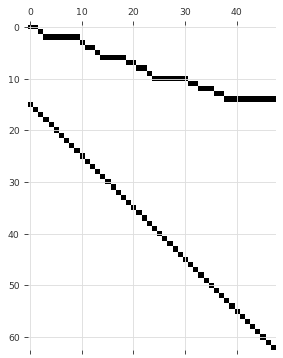

In [32]:
spec = [
    ['STORE_NAME'],
    ['STORE_NAME', 'PRODUCT_NAME'],
]

Y_df, S_df, tags = aggregate(
    df,
    spec,
    time_col=TIME_COL,
    target_cols=[TARGET_COLS]
)

reconcilers = [
    BottomUp(),
    # MinTrace(method='ols'),
    # MinTrace(method='wls_var'),
    # MinTrace(method='mint_shrink'),
    # ERM(method='closed')
]

eval_tags = {}
eval_tags['Total'] = tags['STORE_NAME']
eval_tags['PRODUCT_NAME'] = tags['STORE_NAME/PRODUCT_NAME']

display(Y_df.head())
print(f"S_df.shape: {S_df.shape}")
display(S_df.iloc[:5, :5])

hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()

In [33]:
Y_test_df = Y_df.groupby('unique_id', as_index=False).tail(HORIZON)
Y_train_df = Y_df.drop(Y_test_df.index)
Y_train_df


,unique_id,ORDER_DATE,ORDER_QTY
0,Advanced Bike Components,2011-05-01,0.0
1,Advanced Bike Components,2011-06-01,0.0
2,Advanced Bike Components,2011-07-01,0.0
3,Advanced Bike Components,2011-08-01,5.0
4,Advanced Bike Components,2011-09-01,0.0
...,...,...,...
2322,"Vigorous Exercise Company/Sport-100 Helmet, Red",2013-09-01,0.0
2323,"Vigorous Exercise Company/Sport-100 Helmet, Red",2013-10-01,9.0
2324,"Vigorous Exercise Company/Sport-100 Helmet, Red",2013-11-01,0.0
2325,"Vigorous Exercise Company/Sport-100 Helmet, Red",2013-12-01,0.0


In [34]:
# Hierarchies and reconcilers definition
# Train test split

# same as before

In [35]:
# Compute base forecasts (not coherent)

# SeasonalNaive, TSB,  ADIDA, CrostonClassic(),
models = [AutoETS(season_length=4, model='ZZA'), Naive(), AutoARIMA(), ]
model_names = [m.__class__.__name__ for m in models]


fcst = StatsForecast(
    models=models,
    freq=FREQ,
    n_jobs=-1,
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    Y_hat_df = fcst.forecast(
        df=Y_train_df,
        h=HORIZON,
        fitted=True,
        time_col=TIME_COL,
        target_col=TARGET_COLS,
        level=LEVEL
    )

    Y_fitted_df = fcst.forecast_fitted_values()

In [36]:
# Forecast reconciliation

hrec = HierarchicalReconciliation(reconcilers=reconcilers)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    Y_rec_df = hrec.bootstrap_reconcile(
        Y_hat_df=Y_hat_df,
        Y_df=Y_fitted_df,
        S_df=S_df,
        tags=tags,
        level=LEVEL,
        intervals_method=intervals_method,
        num_samples=10, 
        num_seeds=10,
        time_col=TIME_COL,
        target_col=TARGET_COLS,
    )

display(Y_fitted_df.head(3))
# display(Y_rec_df.sample(5))


,unique_id,ORDER_DATE,ORDER_QTY,AutoETS,AutoETS-lo-98,AutoETS-lo-96,AutoETS-lo-94,AutoETS-lo-92,AutoETS-lo-90,AutoETS-lo-88,AutoETS-lo-86,AutoETS-lo-84,AutoETS-lo-82,AutoETS-lo-80,AutoETS-lo-78,AutoETS-lo-76,AutoETS-lo-74,AutoETS-lo-72,AutoETS-lo-70,AutoETS-lo-68,AutoETS-lo-66,AutoETS-lo-64,AutoETS-lo-62,AutoETS-lo-60,AutoETS-lo-58,AutoETS-lo-56,AutoETS-lo-54,AutoETS-lo-52,AutoETS-lo-50,AutoETS-lo-48,AutoETS-lo-46,AutoETS-lo-44,AutoETS-lo-42,AutoETS-lo-40,AutoETS-lo-38,AutoETS-lo-36,AutoETS-lo-34,AutoETS-lo-32,AutoETS-lo-30,AutoETS-lo-28,AutoETS-lo-26,AutoETS-lo-24,AutoETS-lo-22,AutoETS-lo-20,AutoETS-lo-18,AutoETS-lo-16,AutoETS-lo-14,AutoETS-lo-12,AutoETS-lo-10,AutoETS-lo-8,AutoETS-lo-6,AutoETS-lo-4,AutoETS-lo-2,AutoETS-lo-0,AutoETS-hi-0,AutoETS-hi-2,AutoETS-hi-4,AutoETS-hi-6,AutoETS-hi-8,AutoETS-hi-10,AutoETS-hi-12,AutoETS-hi-14,AutoETS-hi-16,AutoETS-hi-18,AutoETS-hi-20,AutoETS-hi-22,AutoETS-hi-24,AutoETS-hi-26,AutoETS-hi-28,AutoETS-hi-30,AutoETS-hi-32,AutoETS-hi-34,AutoETS-hi-36,AutoETS-hi-38,AutoETS-hi-40,AutoETS-hi-42,AutoETS-hi-44,AutoETS-hi-46,AutoETS-hi-48,AutoETS-hi-50,AutoETS-hi-52,AutoETS-hi-54,AutoETS-hi-56,AutoETS-hi-58,AutoETS-hi-60,AutoETS-hi-62,AutoETS-hi-64,AutoETS-hi-66,AutoETS-hi-68,AutoETS-hi-70,AutoETS-hi-72,AutoETS-hi-74,AutoETS-hi-76,AutoETS-hi-78,AutoETS-hi-80,AutoETS-hi-82,AutoETS-hi-84,AutoETS-hi-86,AutoETS-hi-88,AutoETS-hi-90,AutoETS-hi-92,AutoETS-hi-94,AutoETS-hi-96,AutoETS-hi-98,Naive,Naive-lo-98,Naive-lo-96,Naive-lo-94,Naive-lo-92,Naive-lo-90,Naive-lo-88,Naive-lo-86,Naive-lo-84,Naive-lo-82,Naive-lo-80,Naive-lo-78,Naive-lo-76,Naive-lo-74,Naive-lo-72,Naive-lo-70,Naive-lo-68,Naive-lo-66,Naive-lo-64,Naive-lo-62,Naive-lo-60,Naive-lo-58,Naive-lo-56,Naive-lo-54,Naive-lo-52,Naive-lo-50,Naive-lo-48,Naive-lo-46,Naive-lo-44,Naive-lo-42,Naive-lo-40,Naive-lo-38,Naive-lo-36,Naive-lo-34,Naive-lo-32,Naive-lo-30,Naive-lo-28,Naive-lo-26,Naive-lo-24,Naive-lo-22,Naive-lo-20,Naive-lo-18,Naive-lo-16,Naive-lo-14,Naive-lo-12,Naive-lo-10,Naive-lo-8,Naive-lo-6,Naive-lo-4,Naive-lo-2,Naive-lo-0,Naive-hi-0,Naive-hi-2,Naive-hi-4,Naive-hi-6,Naive-hi-8,Naive-hi-10,Naive-hi-12,Naive-hi-14,Naive-hi-16,Naive-hi-18,Naive-hi-20,Naive-hi-22,Naive-hi-24,Naive-hi-26,Naive-hi-28,Naive-hi-30,Naive-hi-32,Naive-hi-34,Naive-hi-36,Naive-hi-38,Naive-hi-40,Naive-hi-42,Naive-hi-44,Naive-hi-46,Naive-hi-48,Naive-hi-50,Naive-hi-52,Naive-hi-54,Naive-hi-56,Naive-hi-58,Naive-hi-60,Naive-hi-62,Naive-hi-64,Naive-hi-66,Naive-hi-68,Naive-hi-70,Naive-hi-72,Naive-hi-74,Naive-hi-76,Naive-hi-78,Naive-hi-80,Naive-hi-82,Naive-hi-84,Naive-hi-86,Naive-hi-88,Naive-hi-90,Naive-hi-92,Naive-hi-94,Naive-hi-96,Naive-hi-98,AutoARIMA,AutoARIMA-lo-98,AutoARIMA-lo-96,AutoARIMA-lo-94,AutoARIMA-lo-92,AutoARIMA-lo-90,AutoARIMA-lo-88,AutoARIMA-lo-86,AutoARIMA-lo-84,AutoARIMA-lo-82,AutoARIMA-lo-80,AutoARIMA-lo-78,AutoARIMA-lo-76,AutoARIMA-lo-74,AutoARIMA-lo-72,AutoARIMA-lo-70,AutoARIMA-lo-68,AutoARIMA-lo-66,AutoARIMA-lo-64,AutoARIMA-lo-62,AutoARIMA-lo-60,AutoARIMA-lo-58,AutoARIMA-lo-56,AutoARIMA-lo-54,AutoARIMA-lo-52,AutoARIMA-lo-50,AutoARIMA-lo-48,AutoARIMA-lo-46,AutoARIMA-lo-44,AutoARIMA-lo-42,AutoARIMA-lo-40,AutoARIMA-lo-38,AutoARIMA-lo-36,AutoARIMA-lo-34,AutoARIMA-lo-32,AutoARIMA-lo-30,AutoARIMA-lo-28,AutoARIMA-lo-26,AutoARIMA-lo-24,AutoARIMA-lo-22,AutoARIMA-lo-20,AutoARIMA-lo-18,AutoARIMA-lo-16,AutoARIMA-lo-14,AutoARIMA-lo-12,AutoARIMA-lo-10,AutoARIMA-lo-8,AutoARIMA-lo-6,AutoARIMA-lo-4,AutoARIMA-lo-2,AutoARIMA-lo-0,AutoARIMA-hi-0,AutoARIMA-hi-2,AutoARIMA-hi-4,AutoARIMA-hi-6,AutoARIMA-hi-8,AutoARIMA-hi-10,AutoARIMA-hi-12,AutoARIMA-hi-14,AutoARIMA-hi-16,AutoARIMA-hi-18,AutoARIMA-hi-20,AutoARIMA-hi-22,AutoARIMA-hi-24,AutoARIMA-hi-26,AutoARIMA-hi-28,AutoARIMA-hi-30,AutoARIMA-hi-32,AutoARIMA-hi-34,AutoARIMA-hi-36,AutoARIMA-hi-38,AutoARIMA-hi-40,AutoARIMA-hi-42,AutoARIMA-hi-44,AutoARIMA-hi-46,AutoARIMA-hi-48,AutoARIMA-hi-50,AutoARIMA-hi-52,AutoARIMA-hi-54,AutoARIMA-hi-56,AutoARIMA-hi-58,AutoARIMA-hi-60,AutoARIMA-hi-62,AutoARIMA-hi-64,AutoARIMA-hi-66,AutoARIMA-hi-68,AutoARIMA-hi-7

In [37]:
Y_rec_df = Y_rec_df.merge(Y_test_df, on=['unique_id', TIME_COL], how="left")
# Y_rec_df.head(3)

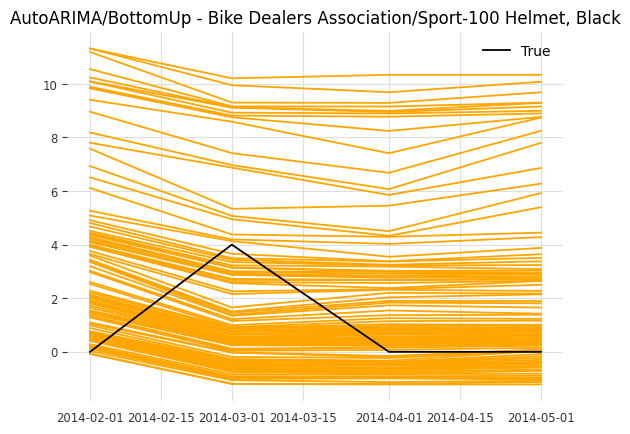

In [38]:
# unique_id = 'Advanced Bike Components' #"total"
unique_id = 'Bike Dealers Association/Sport-100 Helmet, Black'

plot_df = Y_rec_df.query("unique_id == @unique_id").groupby(["unique_id", TIME_COL], as_index=False).mean()
for col in hrec.level_names['AutoARIMA/BottomUp']:
    plt.plot(plot_df[TIME_COL], plot_df[col], color="orange")
plt.plot(plot_df[TIME_COL], plot_df[TARGET_COLS], label="True")
plt.title(f"AutoARIMA/BottomUp - {unique_id}")
plt.legend()


In [39]:
# Evaluate Models CRPS and MSSE

metrics_seeds = []
for seed in Y_rec_df.seed.unique():
    df_seed = Y_rec_df.query("seed == @seed")
    metrics_seed = evaluate(
        df = df_seed,
        tags = tags,
        metrics = [scaled_crps, 
        partial(msse, seasonality=4)],
        models= hrec.level_names.keys(),
        level = LEVEL,
        train_df = Y_train_df,
        time_col=TIME_COL,
        target_col=TARGET_COLS,
    )
    metrics_seed['seed'] = seed
    metrics_seeds.append(metrics_seed)
metrics_seeds = pd.concat(metrics_seeds)

metrics_mean = metrics_seeds.groupby(["level", "metric"], as_index=False).mean()
metrics_std = metrics_seeds.groupby(["level", "metric"], as_index=False).std()

results = metrics_mean[hrec.level_names.keys()].round(3).astype(str) + "±" + metrics_std[hrec.level_names.keys()].round(4).astype(str)
results.insert(0, "metric", metrics_mean["metric"])
results.insert(0, "level", metrics_mean["level"])

results.sort_values(by=["metric", "level"])


,level,metric,AutoETS/BottomUp,Naive/BottomUp,AutoARIMA/BottomUp
0,Overall,msse,0.438±0.0,0.567±0.0,0.352±0.0
2,STORE_NAME,msse,0.39±0.0,0.436±0.0,0.298±0.0
4,STORE_NAME/PRODUCT_NAME,msse,0.453±0.0,0.608±0.0,0.368±0.0
1,Overall,scaled_crps,1.166±0.0362,1.726±0.0266,1.096±0.0295
3,STORE_NAME,scaled_crps,1.09±0.042,1.322±0.0303,0.997±0.0302
5,STORE_NAME/PRODUCT_NAME,scaled_crps,1.19±0.0345,1.852±0.0276,1.127±0.0295


In [40]:
# # Evaluate with reconciliation
# # df = Y_rec_df.merge(Y_test_df, on=['unique_id', TIME_COL], how="left")
# eval_df = Y_rec_df.merge(Y_test_df, on=['unique_id', TIME_COL])

# evaluation = evaluate(
#     df = eval_df,
#     tags = eval_tags,
#     train_df = Y_train_df,
#     metrics = [rmse, partial(mase, seasonality=4)],
#     time_col=TIME_COL,
#     target_col=TARGET_COLS,
# )

# # evaluation.columns = ['level', 'metric', 'Base', 'BottomUp', 'MinTrace(mint_shrink)', 'MinTrace(ols)']
# numeric_cols = evaluation.select_dtypes(include="number").columns
# evaluation[numeric_cols] = evaluation[numeric_cols].map('{:.2f}'.format).astype(np.float64)

# display(evaluation.query('metric == "rmse"'))
# display(evaluation.query('metric == "mase"'))

## <p style="background-color:#56BBD1;font-family:newtimeroman;color:#2E3035;font-size:150%;text-align:center;border-radius:10px 10px;">Bonus B: Probabilistic Forecast Evaluation</p>

Calculating prediction intervals for all hierarchies.

[4] https://nixtlaverse.nixtla.io/hierarchicalforecast/examples/australiandomestictourism-bootstraped-intervals.html

In [58]:

# LEVEL = np.arange(0, 100, 2)
# qs = [[50-lv/2, 50+lv/2] for lv in LEVEL]
# quantiles = np.sort(np.concatenate(qs)[1:]/100)
intervals_method = 'bootstrap' # normality bootstrap permbu


In [59]:
# Hierarchies and reconcilers definition
# Train test split

# same as before

In [60]:
# Compute base forecasts (not coherent)

# SeasonalNaive, TSB,  ADIDA, CrostonClassic(),
models = [AutoETS(season_length=4, model='ZZA'), Naive(), AutoARIMA(), ]
model_names = [m.__class__.__name__ for m in models]


fcst = StatsForecast(
    models=models,
    freq=FREQ,
    n_jobs=-1,
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    Y_hat_df = fcst.forecast(
        df=Y_train_df,
        h=HORIZON,
        fitted=True,
        time_col=TIME_COL,
        target_col=TARGET_COLS,
        level=LEVEL
    )

    Y_fitted_df = fcst.forecast_fitted_values()

In [61]:
# Forecast reconciliation

hrec = HierarchicalReconciliation(reconcilers=reconcilers)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    Y_rec_df = hrec.bootstrap_reconcile(
        Y_hat_df=Y_hat_df,
        Y_df=Y_fitted_df,
        S_df=S_df,
        tags=tags,
        # level=LEVEL,
        level=[80, 90],
        intervals_method=intervals_method,
        num_samples=10, 
        num_seeds=10,
        time_col=TIME_COL,
        target_col=TARGET_COLS,
    )

display(Y_fitted_df.head(3))
# display(Y_rec_df.sample(5))


,unique_id,ORDER_DATE,ORDER_QTY,AutoETS,AutoETS-lo-98,AutoETS-lo-96,AutoETS-lo-94,AutoETS-lo-92,AutoETS-lo-90,AutoETS-lo-88,AutoETS-lo-86,AutoETS-lo-84,AutoETS-lo-82,AutoETS-lo-80,AutoETS-lo-78,AutoETS-lo-76,AutoETS-lo-74,AutoETS-lo-72,AutoETS-lo-70,AutoETS-lo-68,AutoETS-lo-66,AutoETS-lo-64,AutoETS-lo-62,AutoETS-lo-60,AutoETS-lo-58,AutoETS-lo-56,AutoETS-lo-54,AutoETS-lo-52,AutoETS-lo-50,AutoETS-lo-48,AutoETS-lo-46,AutoETS-lo-44,AutoETS-lo-42,AutoETS-lo-40,AutoETS-lo-38,AutoETS-lo-36,AutoETS-lo-34,AutoETS-lo-32,AutoETS-lo-30,AutoETS-lo-28,AutoETS-lo-26,AutoETS-lo-24,AutoETS-lo-22,AutoETS-lo-20,AutoETS-lo-18,AutoETS-lo-16,AutoETS-lo-14,AutoETS-lo-12,AutoETS-lo-10,AutoETS-lo-8,AutoETS-lo-6,AutoETS-lo-4,AutoETS-lo-2,AutoETS-lo-0,AutoETS-hi-0,AutoETS-hi-2,AutoETS-hi-4,AutoETS-hi-6,AutoETS-hi-8,AutoETS-hi-10,AutoETS-hi-12,AutoETS-hi-14,AutoETS-hi-16,AutoETS-hi-18,AutoETS-hi-20,AutoETS-hi-22,AutoETS-hi-24,AutoETS-hi-26,AutoETS-hi-28,AutoETS-hi-30,AutoETS-hi-32,AutoETS-hi-34,AutoETS-hi-36,AutoETS-hi-38,AutoETS-hi-40,AutoETS-hi-42,AutoETS-hi-44,AutoETS-hi-46,AutoETS-hi-48,AutoETS-hi-50,AutoETS-hi-52,AutoETS-hi-54,AutoETS-hi-56,AutoETS-hi-58,AutoETS-hi-60,AutoETS-hi-62,AutoETS-hi-64,AutoETS-hi-66,AutoETS-hi-68,AutoETS-hi-70,AutoETS-hi-72,AutoETS-hi-74,AutoETS-hi-76,AutoETS-hi-78,AutoETS-hi-80,AutoETS-hi-82,AutoETS-hi-84,AutoETS-hi-86,AutoETS-hi-88,AutoETS-hi-90,AutoETS-hi-92,AutoETS-hi-94,AutoETS-hi-96,AutoETS-hi-98,Naive,Naive-lo-98,Naive-lo-96,Naive-lo-94,Naive-lo-92,Naive-lo-90,Naive-lo-88,Naive-lo-86,Naive-lo-84,Naive-lo-82,Naive-lo-80,Naive-lo-78,Naive-lo-76,Naive-lo-74,Naive-lo-72,Naive-lo-70,Naive-lo-68,Naive-lo-66,Naive-lo-64,Naive-lo-62,Naive-lo-60,Naive-lo-58,Naive-lo-56,Naive-lo-54,Naive-lo-52,Naive-lo-50,Naive-lo-48,Naive-lo-46,Naive-lo-44,Naive-lo-42,Naive-lo-40,Naive-lo-38,Naive-lo-36,Naive-lo-34,Naive-lo-32,Naive-lo-30,Naive-lo-28,Naive-lo-26,Naive-lo-24,Naive-lo-22,Naive-lo-20,Naive-lo-18,Naive-lo-16,Naive-lo-14,Naive-lo-12,Naive-lo-10,Naive-lo-8,Naive-lo-6,Naive-lo-4,Naive-lo-2,Naive-lo-0,Naive-hi-0,Naive-hi-2,Naive-hi-4,Naive-hi-6,Naive-hi-8,Naive-hi-10,Naive-hi-12,Naive-hi-14,Naive-hi-16,Naive-hi-18,Naive-hi-20,Naive-hi-22,Naive-hi-24,Naive-hi-26,Naive-hi-28,Naive-hi-30,Naive-hi-32,Naive-hi-34,Naive-hi-36,Naive-hi-38,Naive-hi-40,Naive-hi-42,Naive-hi-44,Naive-hi-46,Naive-hi-48,Naive-hi-50,Naive-hi-52,Naive-hi-54,Naive-hi-56,Naive-hi-58,Naive-hi-60,Naive-hi-62,Naive-hi-64,Naive-hi-66,Naive-hi-68,Naive-hi-70,Naive-hi-72,Naive-hi-74,Naive-hi-76,Naive-hi-78,Naive-hi-80,Naive-hi-82,Naive-hi-84,Naive-hi-86,Naive-hi-88,Naive-hi-90,Naive-hi-92,Naive-hi-94,Naive-hi-96,Naive-hi-98,AutoARIMA,AutoARIMA-lo-98,AutoARIMA-lo-96,AutoARIMA-lo-94,AutoARIMA-lo-92,AutoARIMA-lo-90,AutoARIMA-lo-88,AutoARIMA-lo-86,AutoARIMA-lo-84,AutoARIMA-lo-82,AutoARIMA-lo-80,AutoARIMA-lo-78,AutoARIMA-lo-76,AutoARIMA-lo-74,AutoARIMA-lo-72,AutoARIMA-lo-70,AutoARIMA-lo-68,AutoARIMA-lo-66,AutoARIMA-lo-64,AutoARIMA-lo-62,AutoARIMA-lo-60,AutoARIMA-lo-58,AutoARIMA-lo-56,AutoARIMA-lo-54,AutoARIMA-lo-52,AutoARIMA-lo-50,AutoARIMA-lo-48,AutoARIMA-lo-46,AutoARIMA-lo-44,AutoARIMA-lo-42,AutoARIMA-lo-40,AutoARIMA-lo-38,AutoARIMA-lo-36,AutoARIMA-lo-34,AutoARIMA-lo-32,AutoARIMA-lo-30,AutoARIMA-lo-28,AutoARIMA-lo-26,AutoARIMA-lo-24,AutoARIMA-lo-22,AutoARIMA-lo-20,AutoARIMA-lo-18,AutoARIMA-lo-16,AutoARIMA-lo-14,AutoARIMA-lo-12,AutoARIMA-lo-10,AutoARIMA-lo-8,AutoARIMA-lo-6,AutoARIMA-lo-4,AutoARIMA-lo-2,AutoARIMA-lo-0,AutoARIMA-hi-0,AutoARIMA-hi-2,AutoARIMA-hi-4,AutoARIMA-hi-6,AutoARIMA-hi-8,AutoARIMA-hi-10,AutoARIMA-hi-12,AutoARIMA-hi-14,AutoARIMA-hi-16,AutoARIMA-hi-18,AutoARIMA-hi-20,AutoARIMA-hi-22,AutoARIMA-hi-24,AutoARIMA-hi-26,AutoARIMA-hi-28,AutoARIMA-hi-30,AutoARIMA-hi-32,AutoARIMA-hi-34,AutoARIMA-hi-36,AutoARIMA-hi-38,AutoARIMA-hi-40,AutoARIMA-hi-42,AutoARIMA-hi-44,AutoARIMA-hi-46,AutoARIMA-hi-48,AutoARIMA-hi-50,AutoARIMA-hi-52,AutoARIMA-hi-54,AutoARIMA-hi-56,AutoARIMA-hi-58,AutoARIMA-hi-60,AutoARIMA-hi-62,AutoARIMA-hi-64,AutoARIMA-hi-66,AutoARIMA-hi-68,AutoARIMA-hi-7

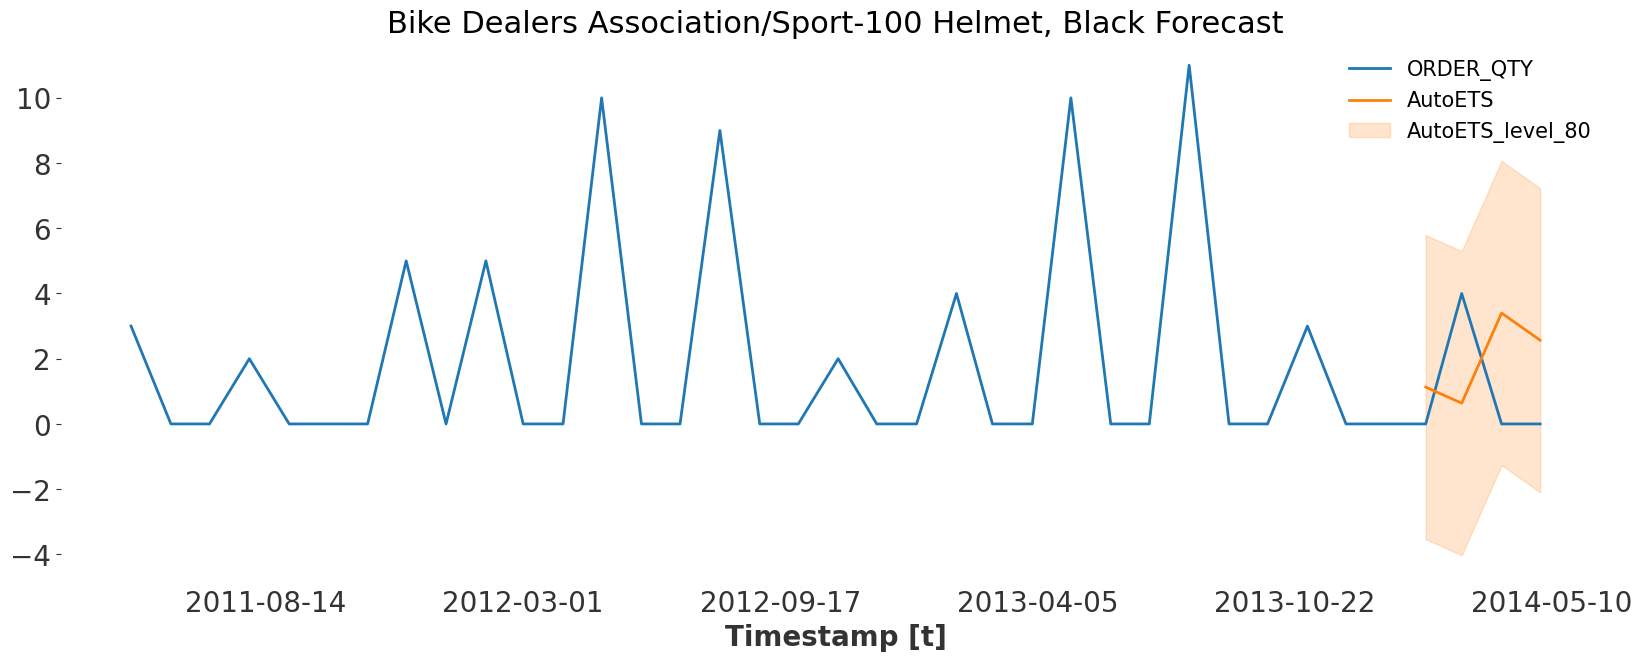

In [62]:
# unique_id = 'Advanced Bike Components' #"total"
unique_id = 'Bike Dealers Association/Sport-100 Helmet, Black'

Y_rec_df = Y_rec_df.merge(Y_test_df, on=['unique_id', TIME_COL], how="left")
plot_df = Y_df.merge(Y_rec_df, on=['unique_id', TIME_COL, TARGET_COLS], how="outer")

hplot.plot_series(
    series=unique_id,
    Y_df=plot_df, 
    models=['ORDER_QTY', 'AutoETS', ],#'AutoETS/MinTrace_method-ols', 'AutoETS/MinTrace_method-mint_shrink'],
    level=[80],
    time_col=TIME_COL,
    target_col=TARGET_COLS,
)


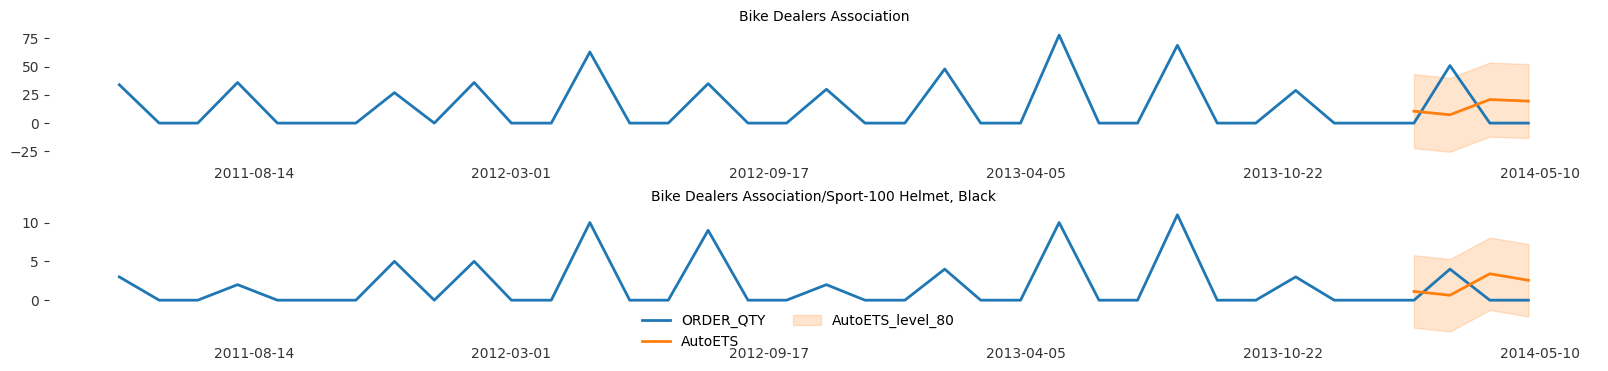

In [64]:
hplot.plot_hierarchically_linked_series(
    bottom_series=unique_id,
    Y_df=plot_df, 
    models=['ORDER_QTY', 'AutoETS', ],#'AutoETS/MinTrace_method-ols', 'AutoETS/BottomUp'],
    level=[80],
    time_col=TIME_COL,
    target_col=TARGET_COLS,
)
